# Clustering 3K PBMCs with Adversarial Autoencoders

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results, plot_results_pca, plot_results_umap
from AAE import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [3]:
data_path = '../data/proc/pbmc10k.h5ad'

In [4]:
adata = sc.read_h5ad(data_path)

In [5]:
adata.obs.shape

(7756, 4)

In [6]:
adata.obs.head()

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACCCAAGATTGTGA-1,2194,0.084903,6160.0,0
AAACCCACATCGGTTA-1,2093,0.061820,6713.0,7
AAACCCAGTACCGCGT-1,1518,0.078911,3637.0,0
AAACCCAGTATCGAAA-1,737,0.088424,1244.0,2
AAACCCAGTCGTCATA-1,1240,0.059747,2611.0,2


In [7]:
adata.var.shape

(1972, 7)

In [8]:
adata.var.head()

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
index,,,,,,,
HES4,ENSG00000188290,Gene Expression,131,True,0.045170,1.462180,1.151113
ISG15,ENSG00000187608,Gene Expression,2282,True,0.697626,1.660043,1.234033
C1orf159,ENSG00000131591,Gene Expression,223,True,0.070364,1.314917,0.663855
TNFRSF18,ENSG00000186891,Gene Expression,373,True,0.133355,1.470949,1.180127
TNFRSF4,ENSG00000186827,Gene Expression,533,True,0.207609,1.508394,1.304025


In [9]:
adata.var_names

Index(['HES4', 'ISG15', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'AL645728.1',
       'MIB2', 'MMP23B', 'MORN1', 'TNFRSF14-AS1',
       ...
       'MX1', 'PWP2', 'AP001059.3', 'AP001059.2', 'COL6A2', 'LSS', 'C21orf58',
       'PCNT', 'DIP2A', 'S100B'],
      dtype='object', name='index', length=1972)

In [10]:
gene_names = adata.var_names.values

In [11]:
data = adata.X
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


### embedding

In [12]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [13]:
genes_encoder = LabelEncoder()
genes_encoded = genes_encoder.fit_transform(gene_names)
print(genes_encoded)

[ 820  942  322 ... 1330  580 1538]


In [14]:
genes_OHE = to_categorical(genes_encoded)

In [15]:
from numpy import argmax

inverted = genes_encoder.inverse_transform([argmax(genes_OHE[0, :])])
print(inverted)

['HES4']


In [16]:
inverted = argmax(genes_OHE[0])
print(inverted)

820


## Adversarial Autoencoder Model

### Network parameters

In [17]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 50
layer_3_dim = 50
batch_size = 35
latent_dim = 50
epochs = 75

In [18]:
encoder, decoder, discriminator, generator, aae = build_AAE(original_dim, latent_dim, layer_1_dim, layer_2_dim, layer_3_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1972)         0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 1972)         0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          197200      DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________

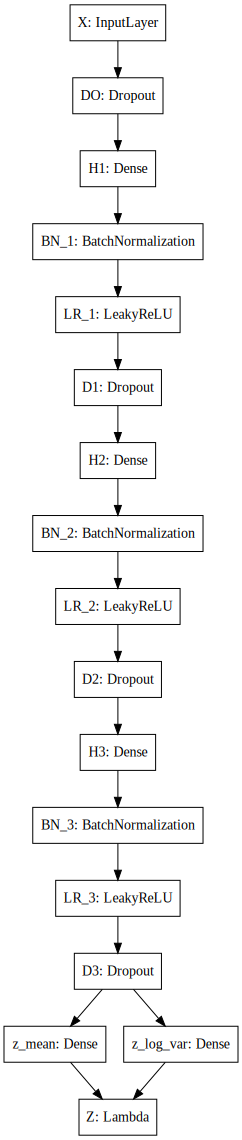

In [19]:
print("\nEncoder Network")
print("===============")
encoder.summary()
os.makedirs('../graphs', exist_ok=True)
plot_model(encoder, to_file='../graphs/aae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 50)                2500      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 50)                0         
_________________________________________________________________
D1 (Dropout)                 (None, 50)                0         
_________________________________________________________________
H2 (Dense)                   (None, 50)                2500

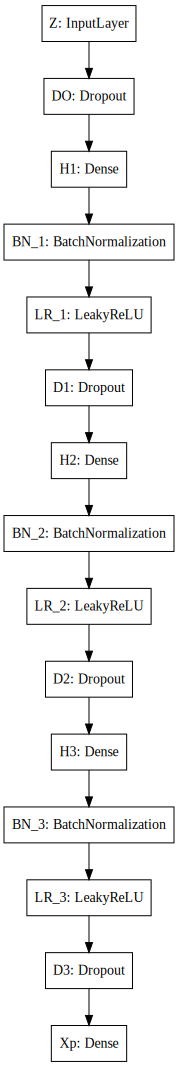

In [20]:
print("\nDecoder Network")
print("===============")
decoder.summary()
plot_model(decoder, to_file='../graphs/aae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1972)              0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  210600    
_________________________________________________________________
decoder (Model)              (None, 1972)              209972    
Total params: 420,572
Trainable params: 419,772
Non-trainable params: 800
_________________________________________________________________


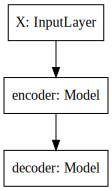

In [21]:
print("\nAutoencoder Network")
print("===================")
aae.summary()
plot_model(aae, to_file='../graphs/aae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))


Generator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1972)              0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  210600    
_________________________________________________________________
discriminator (Model)        (None, 1)                 10901     
Total params: 221,501
Trainable params: 210,200
Non-trainable params: 11,301
_________________________________________________________________


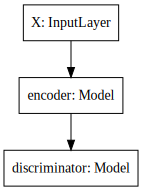

In [22]:
print("\nGenerator Network")
print("===================")

# Freeze the discriminator weights during training of generator
generator.summary()
plot_model(generator, to_file='../graphs/aae_generator.png', show_shapes=True)
SVG(model_to_dot(generator).create(prog='dot', format='svg'))


Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 50)                2500      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 50)                0         
_________________________________________________________________
D1 (Dropout)                 (None, 50)                0         
_________________________________________________________________
H2 (Dense)                   (None, 50)              

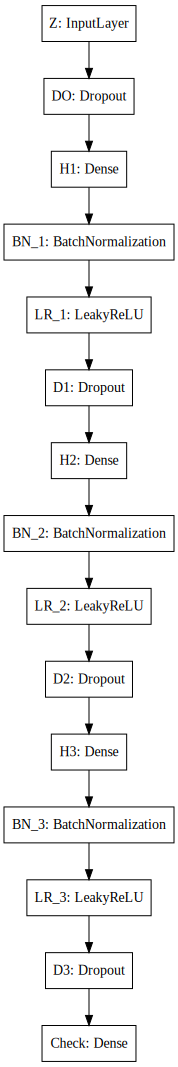

In [23]:
print("\nDiscriminator Network")
print("=====================")

discriminator.trainable = True # note: model already compiled with trainable weights
discriminator.summary()
plot_model(discriminator, to_file='../graphs/aae_discriminator.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

### Model training

Epoch 75/75, reconstruction loss: 0.952352, generation loss: 0.319058, discriminator loss: 0.274497


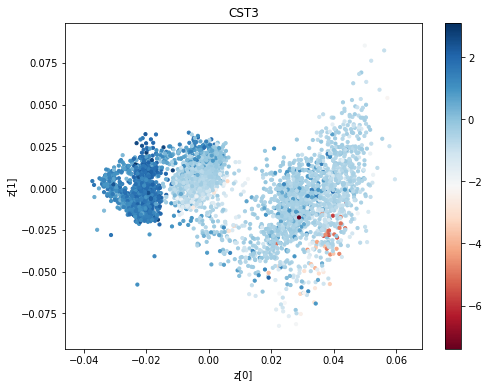

In [24]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

os.makedirs('../models', exist_ok=True)

rec_loss, gen_loss, disc_loss = train_AAE(aae, generator, discriminator, encoder, decoder,
                                          data, batch_size, latent_dim, epochs, 
                                          gene, gene_names, graph=True, 
                                          val_split=0.0)

# save models in h5 format
aae.save('../models/aae_autoencoder.h5')
generator.save('../models/aae_generator.h5')
encoder.save('../models/aae_encoder.h5')
decoder.save('../models/aae_decoder.h5')
discriminator.save('../models/aee_discriminator.h5') 

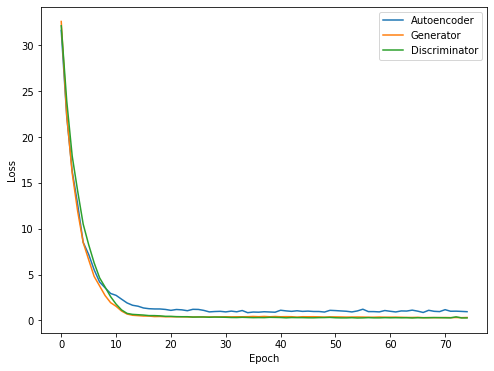

In [25]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

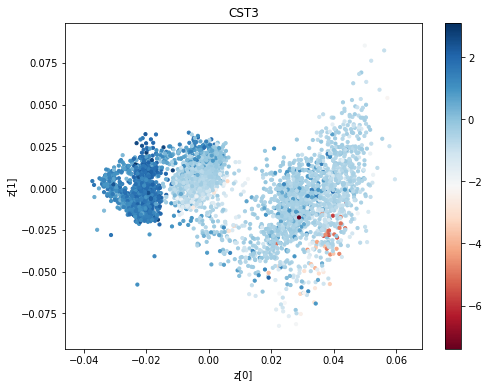

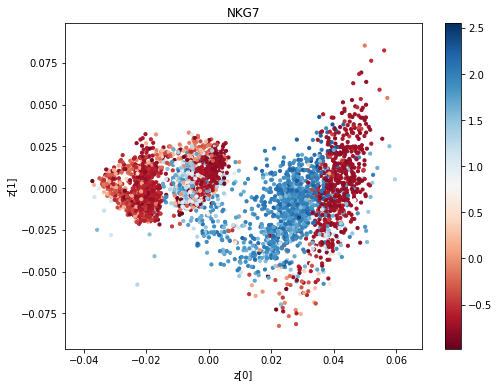

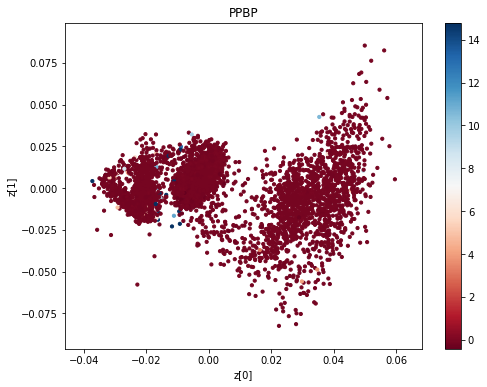

In [26]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)

pca = PCA(n_components=2500)
pca.fit(data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

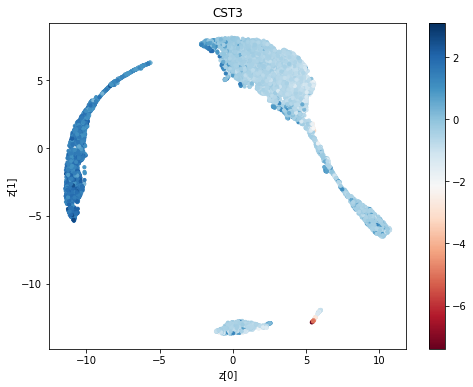

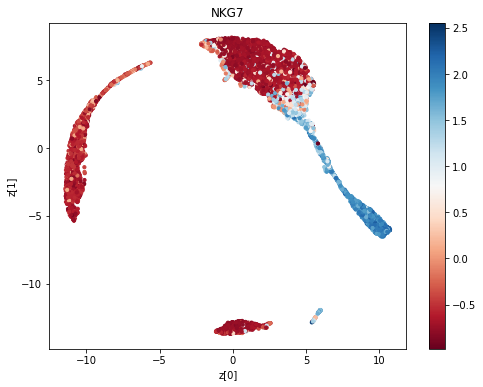

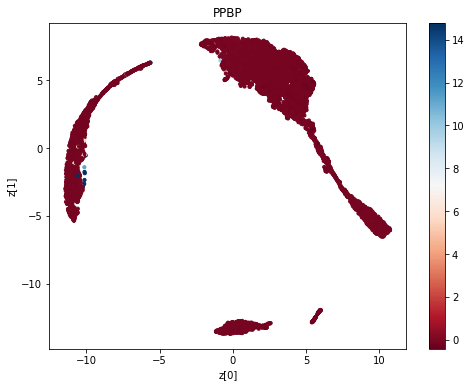

In [27]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_umap(models, data, gene_list, gene_names, latent_dim)